In [42]:
from openai import OpenAI

from dotenv import load_dotenv
import numpy as np
import pandas as pd
import requests
import joblib
import os
import re

import utils

load_dotenv()

True

### Load data

In [43]:
import json

In [44]:
with open('parser/config.json', 'r') as f:
    dataset_name = json.load(f)['dataset_name']

In [45]:
with open(f'data/{dataset_name}.json', 'r') as f:
    projects = json.load(f)

In [46]:
df = utils.load_bids_df(dataset_name=dataset_name)

df['bid_description'] = df['bid_description'].fillna('')

df_prepared = utils.prepare_df(df)

In [47]:
def generate_bid(bid, bid_text):

    # Transforming generated bid text in features
    text_before, text_after = bid_text.split('Description:')

    period = re.findall('(?<=Period of work: )\d+?', text_before)[0]
    bid['bid_period'] = int(period)

    amount = re.findall('(?<=Price of work: \$)\d*', text_before)[0]
    bid['bid_amount'] = float(amount)

    bid['bid_description'] = text_after

    one_bid_df = pd.DataFrame(columns=list(bid.to_dict().keys()), data=[bid.values.tolist()])
    one_bid_df = utils.prepare_df(one_bid_df)

    return one_bid_df

#### Get user data

In [48]:
access_token = '' or os.getenv('FREELANCER_ACCESS_TOKEN')
# /users/0.1/
user_id = '70505411'
url = f"https://www.freelancer.com/api/users/0.1/reputations/"

headers = {'freelancer-oauth-v1': access_token}
params = {"users[]": [int(user_id)]}
response = requests.request("GET", url, headers=headers, params=params)

user_data = response.json()['result'][user_id]

#### ChatGPT API generation

In [49]:
API_KEY = '' or os.getenv('OPENAI_API_KEY')

In [50]:
client = OpenAI(api_key=API_KEY)

system_content = ("You are a freelancer which specializes in machine learning."
                  "You have an understanding of the field, because you have learnt a lot, "
                  "but you haven't done anything important in this field."
                  "You work on freelancer.com and you want to be adwarded for this project."
                  "Propose to the client the way of solving the problem."
                  "You can write no more than 250 words. You need to be polite enough. "
                  "You need to answer by such model: Period of work: [number] days;"
                  " Price of work: $[price]; Description: [your proposition].")

def get_bid_text(project):

    project_title = project['project_title'].iloc[0]
    project_description = project['project_description'].iloc[0]

    project_min_amount = project['project_min_amount'].iloc[0]
    project_max_amount = project['project_max_amount'].iloc[0]

    completion = client.chat.completions.create(
      model="gpt-3.5-turbo",
      messages=[
        {"role": "system", "content": system_content},
        {"role": "user", "content": (f"Title: {project_title}\nProject desired min amount: {project_min_amount}"
                                     f"Project desired max amount: {project_max_amount}\n"
                                     f"Description: {project_description}")}
      ]
    )

    return completion.choices[0].message.content.replace('[Your Name]', '@username')

In [51]:
import random

def get_random_project():

    project_id = random.choice(df['project_id'].unique())
    project_bids_indexes = np.where(df['project_id'] == project_id)[0]

    project = df.iloc[project_bids_indexes]

    return project

### Formatting base template

In [52]:
def show_awarded_proportion(df, *args, name=''):
    prop = sum(df['bid_award_status']) / len(df) * 100
    print('Proportion of awarded', name+':', prop, '%', *args)    

#### choosing the best greetings

In [53]:
target_df = df_prepared.loc[df_prepared['bid_greetings'].values.astype(bool)]
show_awarded_proportion(target_df, name='with_greetings')

target_df = df_prepared.loc[~df_prepared['bid_greetings'].values.astype(bool)]
show_awarded_proportion(target_df, name='without_greetings')

Proportion of awarded with_greetings: 8.40949455170551 %
Proportion of awarded without_greetings: 9.57910014513788 %


In [54]:
for greeting in utils.greetings+['greetings']+['regards']:
    target_index = df['bid_description'].apply(lambda x: x.lower()[:30].find(greeting)!=-1)
    target_df = df.loc[target_index]
    
    if len(target_df) > 0.:
        show_awarded_proportion(target_df, len(target_df), name=greeting)
        
        target_df = df.loc[~target_index]
        show_awarded_proportion(target_df, len(target_df), name='without_'+greeting)
        print()

Proportion of awarded good afternoon: 0.0 % 5
Proportion of awarded without_good afternoon: 8.458961474036851 % 9552

Proportion of awarded good morning: 0.0 % 6
Proportion of awarded without_good morning: 8.459847136425505 % 9551

Proportion of awarded how are you: 20.603015075376884 % 398
Proportion of awarded without_how are you: 7.926629544710122 % 9159

Proportion of awarded dear sir: 8.108108108108109 % 74
Proportion of awarded without_dear sir: 8.45723927027312 % 9483

Proportion of awarded hi: 7.760090960773167 % 3518
Proportion of awarded without_hi: 8.859082629574432 % 6039

Proportion of awarded hello: 7.920792079207921 % 2222
Proportion of awarded without_hello: 8.61622358554874 % 7335

Proportion of awarded greetings: 20.88235294117647 % 340
Proportion of awarded without_greetings: 7.996094173809265 % 9217

Proportion of awarded regards: 0.0 % 2
Proportion of awarded without_regards: 8.456305599162741 % 9555



In [55]:
target_index = df['bid_description'].apply(lambda x: x.lower().find('how are you')!=-1)
target_df = df.loc[target_index]

print('\n\n'.join([text[:40] for text in target_df['bid_description'].head(5).values]))

Hello, how are you? 
 I just saw your jo

Greetings!
How are you today?
Thanks for

Hi, How are you? 
Very glad to bid your 

Hi. How are you? 
I have just read your 

Hello, How Are You? I have read your job


In [56]:
df_without_sealed = df.drop(np.where(df['bid_sealed'])[0]).reset_index(drop=True)

for greeting in [['hello', 'how are you'], ['hi', 'how are you'], ['greetings', 'how are you']]:
    target_index = df_without_sealed['bid_description'].apply(lambda x: x.lower()[:30]
                                              ).apply(lambda x: x.find(greeting[0])!=-1 and x.find(greeting[1])!=-1)
    target_df = df_without_sealed.loc[target_index]
    
    if len(target_df) > 0.:
        show_awarded_proportion(target_df, len(target_df), name=greeting[0])
        
        target_df = df_without_sealed.loc[~target_index]
        show_awarded_proportion(target_df, len(target_df), name='without_'+greeting[0])
        print()

Proportion of awarded hello: 11.956521739130435 % 92
Proportion of awarded without_hello: 8.06233893729292 % 8149

Proportion of awarded hi: 12.70718232044199 % 181
Proportion of awarded without_hi: 8.002481389578165 % 8060

Proportion of awarded greetings: 50.56179775280899 % 89
Proportion of awarded without_greetings: 7.642296368989205 % 8152



In [57]:
target_index = df_without_sealed['bid_description'].apply(lambda x: x.lower()[:30]
                                        ).apply(lambda x: x.find('greetings')!=-1 and x.find('how are you')!=-1)
df_without_sealed.loc[target_index]['bid_description'].apply(lambda x: x[:50]).head()

17     Greetings!\nHow are you today?\nThanks for pos...
131    Greetings!\nHow are you today?\nThanks for pos...
527    Greetings!\nHow are you today?\nThanks for pos...
576    Greetings!\nHow are you today?\nThanks for pos...
665    Greetings!\nHow are you today?\nThanks for pos...
Name: bid_description, dtype: object

In [58]:
target_index = df_without_sealed['bid_description'].apply(lambda x: x.lower()[:30]
                                        ).apply(lambda x: x.find('hi')!=-1 and x.find('how are you')!=-1)
df_without_sealed.loc[target_index]['bid_description'].apply(lambda x: x[:50]).head()

24     Hi, How are you? \nVery glad to bid your proje...
38     Hi. How are you? \nI have just read your propo...
269    Hi, How are you? \nVery glad to bid your proje...
290    Hi, How are you?\nUpon reading brief details I...
296    Hi, How are you? I am expert in Matlab and mac...
Name: bid_description, dtype: object

Greetings: Hi, How are you?

#### finding optimal length

In [59]:
corr_matrix = df_prepared.corr()
corr_matrix['bid_award_status'].sort_values(ascending=False)[['bid_descr_len', 'proj/bid_lens_proportion']]

bid_descr_len              -0.050411
proj/bid_lens_proportion   -0.016700
Name: bid_award_status, dtype: float64

array([[<Axes: title={'center': 'bid_descr_len'}>,
        <Axes: title={'center': 'proj/bid_lens_proportion'}>]],
      dtype=object)

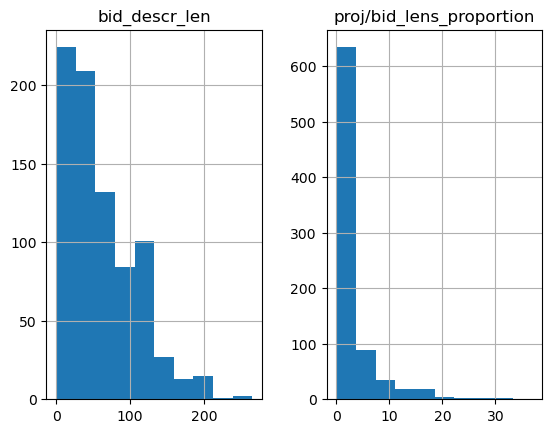

In [60]:
df_prepared[df['bid_award_status'].astype(bool)][['bid_descr_len', 'proj/bid_lens_proportion']].hist()

In [61]:
target_df = df_prepared.loc[(df_prepared['bid_descr_len'] > 30.) & (~df_prepared['bid_sealed'].astype(bool)) & 
                            (df['bid_award_status'].astype(bool) )] # ignoring descr of 5 words

mean_word_len = 5
bid_len = target_df['bid_descr_len'].mean()

print('mean:', round(bid_len/mean_word_len),'words')

mean: 16 words


In [62]:
target_df = df_prepared.loc[(df_prepared['proj/bid_lens_proportion'] > 0.) & (~df_prepared['bid_sealed'].astype(bool)) & 
                            (df['bid_award_status'].astype(bool) )] # ignoring descr of 5 words

proportion = target_df['proj/bid_lens_proportion'].mean()

print(f'mean: {round(1 / proportion*100)}% of project len')

mean: 28% of project len


#### others columns

In [63]:
df_prepared.columns

Index(['project_id', 'bid_score', 'bid_sealed', 'bid_period', 'bid_quality',
       'bid_communication', 'bid_professionalism', 'bid_award_status',
       'project/bid_amount_proportion', 'bid_delay',
       'same_words_title/bid_proportion', 'same_words_descr/bid_proportion',
       'bid_descr_len', 'proj/bid_lens_proportion', 'bid_greetings'],
      dtype='object')

with others columns, it's better than higgher, such as than faster will be written bid, than better

### Writting with using simple model

#### Load estimator

In [64]:
estimator = joblib.load('estimators/ml_bids_estimator.json')

In [65]:
def predict_bids_probs(bids):
    return estimator.predict_proba(bids)[:, 1].reshape(-1)

In [66]:
def predict_generated_bids_probs(best_bid, bids_texts):

    bids = [generate_bid(best_bid.copy(), bid_text) for bid_text in bids_texts]

    bids = pd.concat(bids)
    pred = predict_bids_probs(bids)

    return pred, bids

#### Generating text

In [67]:
system_content = ("You are a freelancer which specializes in machine learning."
                  "You have an understanding of the field, because you have learnt a lot, "
                  "but you haven't done anything important in this field."
                  "You work on freelancer.com and you want to be adwarded for this project."
                  "Try to asnwwer as short as possible with the key idea is to show that you know your work. "
                  "You need to answer by such template: Period of work: [number] days;"
                  " Price of work: $[price]; Description: Hi, How are you? [your proposition]")
# taken from the section "Load model with pretrained embeddings"

In [73]:
# variables for future analyze
best_properties = {elem: {} for elem in ['predicted', 'labeled']}
iterations = {}

n = 3
for i in range(n):

    iteration_env = {}

    project = get_random_project().reset_index(drop=True)
    df_project = utils.prepare_df(project)

    best_index = np.where(project['bid_award_status'])[0][0]
    for col in df_project.columns:
        if col in ['project_id', 'bid_award_status']: continue

        if not best_properties.get(col, False):
            best_properties['labeled'][col] = 0

        best_properties['labeled'][col] += df_project.iloc[best_index][col]

    iteration_env['project'] = project

    probs = predict_bids_probs(df_project) * 100
    probs_descending = np.argsort(probs)[::-1]

    print('Probs of others bids: ', probs[probs_descending[:5]])
    iteration_env['project_probs'] = probs

    project_without_sealed_bids = project.drop(np.where(project['bid_sealed'])[0])
    df_project_without_sealed_bids = utils.prepare_df(project_without_sealed_bids)

    probs = predict_bids_probs(df_project_without_sealed_bids) * 100
    probs_descending = np.argsort(probs)[::-1]

    print('Probs of not sealed bids: ', probs[probs_descending[:5]])
    iteration_env['project_without_sealed'] = project_without_sealed_bids
    iteration_env['project_without_sealed_probs'] = probs

    index = np.argmax(probs)

    for col in df_project.columns:
        if not best_properties.get(col, False):
            best_properties['predicted'][col] = 0

        best_properties['predicted'][col] += df_project.iloc[index][col]

    bids_texts = [get_bid_text(project) for i in range(4)]

    probs,bids = predict_generated_bids_probs(project.iloc[index].copy(),
                                              bids_texts)
    print(f'Probability to be awarded: {probs* 100}')
    iteration_env['bids_texts'] = bids_texts
    iteration_env['generated_bids_probs'] = probs

    iteration_env['best_bid'] = project.iloc[index]

    print()

    # saving
    iterations[df_project.iloc[best_index]['project_id']] = iteration_env

Probs of others bids:  [35.79668834 33.44920488  3.06132837  1.99178103]
Probs of not sealed bids:  [35.79668834 33.44920488  3.06132837  1.99178103]
Probability to be awarded: [28.47651313 31.06716669 28.8585958  32.07818799]

Probs of others bids:  [38.83992901 33.59302276 29.91519951 29.44325646  5.89051098]
Probs of not sealed bids:  [38.83992901 33.59302276 29.91519951 29.44325646  5.89051098]
Probability to be awarded: [28.3631246  28.2562043  28.48847254 28.3607275 ]

Probs of others bids:  [40.19344145 35.0323068  31.83474841 31.13731163 29.85383461]
Probs of not sealed bids:  [40.19344145 31.83474841 28.16496407 27.97933866 26.154414  ]
Probability to be awarded: [23.25619089 24.89429766 14.4398102  19.92684493]



In [74]:
print('Project description:', project['project_description'][0]), print()

for i, (prob,bid_text) in enumerate(zip(probs, bids_texts)):
    print(f'Attempt: {i}, Prob: {round(prob*100,2)}%\n{bid_text}'), print()

Project description: Clustering time series data using k shape or other time series clustering algorithm

Attempt: 0, Prob: 23.26%
Period of work: 5 days
Price of work: $150
Description: Hi, How are you? I have expertise in clustering time series data using k shape and other time series clustering algorithms. I can complete this project within 5 days for a price of $150.

Attempt: 1, Prob: 24.89%
Period of work: 5 days; 
Price of work: $150; 
Description: Hi, How are you? I have experience in clustering time series data using k shape algorithm. I can help you analyze and cluster your time series data efficiently. Let's discuss your requirements in detail and get started on the project.

Attempt: 2, Prob: 14.44%
Period of work: 7 days; Price of work: $200; 

Description: Hi, I hope you're doing well. I have experience in clustering time series data using k shape and other time series clustering algorithms. I can work on your project and deliver the results within 7 days for a total pric

### Writting with using DNN with embeddings for text analyze

In [70]:
import tensorflow as tf
import tensorflow_hub as hub

2023-12-13 06:28:06.411886: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-13 06:28:07.130516: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-13 06:28:09.627776: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [71]:
preprocess = joblib.load('models/pipeline.json')

#### Load model with pretrained embeddings

In [ ]:
model = tf.keras.models.load_model('models/ml_projects_vector_embeddings_model.h5',
                                   custom_objects={"KerasLayer": hub.KerasLayer})

In [ ]:
X_1, X_2 = df['project_description'].values, df['bid_description'].values
X_3 = preprocess.transform(df_prepared).astype('float32')

In [ ]:
def predict_bids_probs(bids):
    return model.predict(bids, verbose=0).reshape(-1)

In [ ]:
def prepare_data(project):

    df = utils.prepare_df(project)

    x_2 = preprocess.transform(df).astype('float32')
    bids = ( project['project_description'].values, project['bid_description'].values, x_2)

    return bids

In [ ]:
def predict_generated_bids_probs(best_bid, bids_texts):
    bids = [generate_bid(best_bid.copy(), bid_text) for bid_text in bids_texts]

    x_2 = preprocess.transform(pd.concat(bids)).astype('float32')
    bids = ( np.repeat(best_bid['project_description'], len(bids)),
             np.array(bids_texts), x_2)

    pred = predict_bids_probs(bids)

    return pred, bids

##### Generating text

In [ ]:
# variables for future analyze
best_properties = {elem: {} for elem in ['predicted', 'labeled']}
iterations = {}

n = 3
for i in range(n):

    iteration_env = {}

    project = get_random_project().reset_index(drop=True)
    df_project = utils.prepare_df(project)

    best_index = np.where(project['bid_award_status'])[0][0]
    for col in df_project.columns:
        if col in ['project_id', 'bid_award_status']: continue

        if not best_properties.get(col, False):
            best_properties['labeled'][col] = 0

        best_properties['labeled'][col] += df_project.iloc[best_index][col]

    iteration_env['project'] = project

    probs = predict_bids_probs(prepare_data(project)) * 100
    probs_descending = np.argsort(probs)[::-1]

    print('Probs of others bids: ', probs[probs_descending[:5]])
    iteration_env['project_probs'] = probs

    project_without_sealed_bids = project.drop(np.where(project['bid_sealed'])[0])

    probs = predict_bids_probs(prepare_data(project_without_sealed_bids)) * 100
    probs_descending = np.argsort(probs)[::-1]

    print('Probs of not sealed bids: ', probs[probs_descending[:5]])
    iteration_env['project_without_sealed'] = project_without_sealed_bids
    iteration_env['project_without_sealed_probs'] = probs

    index = np.argmax(probs)

    for col in df_project.columns:
        if not best_properties.get(col, False):
            best_properties['predicted'][col] = 0

        best_properties['predicted'][col] += df_project.iloc[index][col]

    bids_texts = [get_bid_text(project) for i in range(4)]

    probs,bids = predict_generated_bids_probs(project.iloc[index].copy(),
                                              bids_texts)
    print(f'Probability to be awarded: {probs* 100}')
    iteration_env['bids_texts'] = bids_texts
    iteration_env['generated_bids_probs'] = probs

    iteration_env['best_bid'] = project.iloc[index]

    print()

    # saving
    iterations[df_project.iloc[best_index]['project_id']] = iteration_env

Probs of others bids:  [91.15503  77.07206  75.58336  68.28451  46.655952]
Probs of not sealed bids:  [91.15503  46.655952 29.696148 28.29905  19.53961 ]
Probability to be awarded: [5.8478584 9.262669  3.703593  2.8786018]

Probs of others bids:  [77.7794   75.568695 67.23305  65.44382  60.364048]
Probs of not sealed bids:  [67.23305  65.44382  60.364048 49.740814 30.55838 ]
Probability to be awarded: [6.3783684e+00 4.1249595e-03 4.7295406e-01 6.9040668e-01]

Probs of others bids:  [86.53886  81.649086 10.243407  8.811051  6.774966]
Probs of not sealed bids:  [10.243407   8.811051   6.774966   5.7837543  5.542145 ]
Probability to be awarded: [ 5.7100253 21.795374  19.38219   10.3059845]



In [ ]:
best_bid = project.iloc[index].copy()
a = best_bid.to_dict()

In [ ]:
utils.prepare_df(pd.DataFrame(columns=list(a.keys()), data=[list(a.values())]))

,project_id,bid_score,bid_sealed,bid_period,bid_quality,bid_communication,bid_professionalism,bid_award_status,project/bid_amount_proportion,bid_delay,same_words_title/bid_proportion,same_words_descr/bid_proportion,bid_descr_len,proj/bid_lens_proportion,bid_greetings
0,34921562.0,0.716542,False,7.0,4.86209,4.931045,4.931045,False,16.666667,0.06688,0.333333,0.153846,191.0,2.850746,True


In [ ]:
bids = [generate_bid(best_bid.copy(), bid_text) for bid_text in bids_texts]

pd.concat(bids)

,project_id,bid_score,bid_sealed,bid_period,bid_quality,bid_communication,bid_professionalism,bid_award_status,project/bid_amount_proportion,bid_delay,same_words_title/bid_proportion,same_words_descr/bid_proportion,bid_descr_len,proj/bid_lens_proportion,bid_greetings
0,34921562.0,0.716542,False,7.0,4.86209,4.931045,4.931045,False,6.666667,0.06688,0.25,0.346154,203.0,3.029851,True
0,34921562.0,0.716542,False,5.0,4.86209,4.931045,4.931045,False,6.666667,0.06688,0.25,0.384615,301.0,4.492537,True
0,34921562.0,0.716542,False,1.0,4.86209,4.931045,4.931045,False,6.666667,0.06688,0.25,0.403846,219.0,3.268657,True
0,34921562.0,0.716542,False,1.0,4.86209,4.931045,4.931045,False,6.000000,0.06688,0.25,0.326923,245.0,3.656716,True


In [ ]:
print('Best:', best_bid['bid_description']), print()
print('Generated:', bids_texts[1].split('Description:')[1])

Best: I have read project requirements. I am managing director of software company and I have team for development so we can complete it perfectly. I am from India GMT +5:30 and I am available from 8:00 AM to 11:00 PM. 

We have 11+ years of experience in software development. We have developed 400+ projects and the research paper in the field of Machine Learning, Artificial Intelligence and Image processing (GIS), Network, SEO based Web and mobile apps.

We have successfully completed the project of phishing detection, Spam mail filter, shortest path, HMM, Encryption decryption, Face detection, UML Diagram, OCR, Big data, data mining, data analysis, Statistics, Trading, Text, Natural Language Processing (NLP), Image, multiclass classification using WEKA, Azure ML, Tensorflow, R Programming, OpenCV, Matlab, Hadoop, Artificial Intelligence program using PROLOG, Robotics software, TCP-UDP Networking project, cloud computing, etc.

View my last projects based on Data Mining, Machine Learn

In [ ]:
system_content = ("You are a freelancer which specializes in machine learning."
                  "You have an understanding of the field, because you have learnt a lot, "
                  "but you haven't done anything important in this field."
                  "You work on freelancer.com and you want to be adwarded for this project."
                  "Try to asnwwer as short as possible with the key idea is to show that you know your work. "
                  "You need to answer by such template: Period of work: [number] days;"
                  " Price of work: $[price]; Description: Hi, How are you? [your proposition]")

bid_text = get_bid_text(project)
print(bid_text.split('Description:')[1])

 I propose to develop a deep learning-based face detection model that can accurately recognize faces and identify any obstructions or features that hide the face, such as hair falling on the face or half of the face being hidden. The model will also be able to detect gender and estimate age if applicable. This solution will ensure clear and accurate face recognition for ID card or similar applications.


In [ ]:
# variables for future analyze
best_properties = {elem: {} for elem in ['predicted', 'labeled']}
iterations = {}

n = 3
for i in range(5):

    iteration_env = {}

    project = get_random_project().reset_index(drop=True)
    df_project = utils.prepare_df(project)

    best_index = np.where(project['bid_award_status'])[0][0]
    for col in df_project.columns:
        if col in ['project_id', 'bid_award_status']: continue

        if not best_properties.get(col, False):
            best_properties['labeled'][col] = 0

        best_properties['labeled'][col] += df_project.iloc[best_index][col]

    iteration_env['project'] = project

    probs = predict_bids_probs(prepare_data(project)) * 100
    probs_descending = np.argsort(probs)[::-1]

    print('Probs of others bids: ', probs[probs_descending[:5]])
    iteration_env['project_probs'] = probs

    project_without_sealed_bids = project.drop(np.where(project['bid_sealed'])[0])

    probs = predict_bids_probs(prepare_data(project_without_sealed_bids)) * 100
    probs_descending = np.argsort(probs)[::-1]

    print('Probs of not sealed bids: ', probs[probs_descending[:5]])
    iteration_env['project_without_sealed'] = project_without_sealed_bids
    iteration_env['project_without_sealed_probs'] = probs

    index = np.argmax(probs)

    for col in df_project.columns:
        if not best_properties.get(col, False):
            best_properties['predicted'][col] = 0

        best_properties['predicted'][col] += df_project.iloc[index][col]

    bids_texts = [get_bid_text(project) for i in range(4)]

    probs,bids = predict_generated_bids_probs(project.iloc[index].copy(),
                                              bids_texts)
    print(f'Probability to be awarded: {probs* 100}')
    iteration_env['bids_texts'] = bids_texts
    iteration_env['generated_bids_probs'] = probs

    iteration_env['best_bid'] = project.iloc[index]

    print()

    # saving
    iterations[df_project.iloc[best_index]['project_id']] = iteration_env

Probs of others bids:  [51.87858   41.10864   28.588327   2.165873   1.8875086]
Probs of not sealed bids:  [51.87858   28.588327   2.165873   1.8875086]
Probability to be awarded: [75.78434  28.293873 74.341095 72.08464 ]

Probs of others bids:  [79.80187  61.897533 61.03295  48.116093 43.186153]
Probs of not sealed bids:  [79.80187  61.03295  48.116093 43.186153 34.525463]
Probability to be awarded: [38.074306 34.116257  8.112202 24.127914]

Probs of others bids:  [67.496185 60.937263 57.340992 50.575966 34.09354 ]
Probs of not sealed bids:  [60.937263 57.340992 50.575966 34.09354  20.058397]
Probability to be awarded: [0.00170735 0.12004651 0.9113481  0.5526526 ]

Probs of others bids:  [91.081924 84.379    79.062294 77.6719   45.41154 ]
Probs of not sealed bids:  [45.411533 30.184332 29.500536 19.140097 13.9881  ]
Probability to be awarded: [84.71293  84.72614  20.14876  57.897823]

Probs of others bids:  [95.234886 84.021774 74.16191  59.424877 56.983864]
Probs of not sealed bids: 

In [ ]:
first_iteration = iterations[list(iterations.keys())[3]] # 3rd
project = first_iteration['project']
project_without_sealed_bids = first_iteration['project_without_sealed']

probs = predict_bids_probs(prepare_data(project_without_sealed_bids)) * 100
probs_descending = np.argsort(probs)[::-1]

index = np.argmax(probs)

In [ ]:
best_bid = project.iloc[index].copy()
a = best_bid.to_dict()

In [ ]:
utils.prepare_df(pd.DataFrame(columns=list(a.keys()), data=[list(a.values())]))

,project_id,bid_score,bid_sealed,bid_period,bid_quality,bid_communication,bid_professionalism,bid_award_status,project/bid_amount_proportion,bid_delay,same_words_title/bid_proportion,same_words_descr/bid_proportion,bid_descr_len,proj/bid_lens_proportion,bid_greetings
0,34192365.0,0.72024,False,7.0,5.0,5.0,5.0,False,1.333333,0.00006,0.25,0.264706,89.0,2.282051,True


In [ ]:
bids_texts = first_iteration['bids_texts']

bids = [generate_bid(best_bid.copy(), bid_text) for bid_text in bids_texts]

pd.concat(bids)

,project_id,bid_score,bid_sealed,bid_period,bid_quality,bid_communication,bid_professionalism,bid_award_status,project/bid_amount_proportion,bid_delay,same_words_title/bid_proportion,same_words_descr/bid_proportion,bid_descr_len,proj/bid_lens_proportion,bid_greetings
0,34192365.0,0.72024,False,1.0,5.0,5.0,5.0,False,6.666667,0.00006,0.375,0.500000,40.0,1.025641,False
0,34192365.0,0.72024,False,1.0,5.0,5.0,5.0,False,6.666667,0.00006,0.375,0.588235,53.0,1.358974,False
0,34192365.0,0.72024,False,7.0,5.0,5.0,5.0,False,5.000000,0.00006,0.250,0.294118,78.0,2.000000,False
0,34192365.0,0.72024,False,1.0,5.0,5.0,5.0,False,6.666667,0.00006,0.500,0.529412,48.0,1.230769,True


In [ ]:
first_iteration['generated_bids_probs'] * 100

array([84.71293 , 84.72614 , 20.14876 , 57.897823], dtype=float32)

In [ ]:
best_bid['project_description']

'I have a dataset containing average traffic at metro stations and want to compare the performance of the following models in predicting traffic at each station GNN, GCN, GAT, HypernetX by comparing the following metrics MAE, MSE, RMSE, MAP\n'

In [ ]:
print('Best:', best_bid['bid_description']), print()
print('Generated:', bids_texts[1].split('Description:')[1])

Best: Hello Sir/ Ma’am

A skilled full stack developer, I have rich experience in JAVA,C,  C++, C#, Python, .NET , MYSQL, SQL, IONIC , MATLAB,PHP and ARDUINO. 

I am very confident with my skills and I'd like to help your business by doing my best.
I am able to work full time on your time zone and start working right away.
Please confirm that I am one of the best fits for you and drop me a message for further discussion.

High-quality & Fast-delivery is promised!

Thanks and Best Regards

Generated:  I propose to develop and implement GNN, GCN, GAT, and HypernetX models using the given dataset for metro traffic prediction. I will compare the performance of these models based on metrics such as MAE, MSE, RMSE, and MAP. The deliverables will include code, model evaluation results, and a comprehensive report summarizing the findings.


here is can be seen that even if this is the best according to model, in truth this bid hasn't been awarded, because text doesn't seem to have any importance for client, while on another project it has generated practically the best prob. The problem in the not very good project desciption, thank of what generation can't be the best

In [ ]:
for prop_name in list(best_properties.values())[0].keys():

    temp_dict = {}
    for dict_key in best_properties.keys():
        value = best_properties[dict_key].get(prop_name, 'unknown')

        if not value == 'unknown':
            temp_dict[dict_key] = value

    if len(temp_dict) != 2: continue

    print(prop_name, temp_dict)

bid_score {'predicted': 1.0311934712077, 'labeled': 0.69862133368271}
bid_sealed {'predicted': 1, 'labeled': 0}
bid_period {'predicted': 4.0, 'labeled': 2.0}
bid_quality {'predicted': 4.991373197999693, 'labeled': 4.7616582417528495}
bid_communication {'predicted': 4.990784271600079, 'labeled': 4.7616582417528495}
bid_professionalism {'predicted': 4.986806067528943, 'labeled': 4.730110505453769}
project/bid_amount_proportion {'predicted': 0.0, 'labeled': 1.0}
bid_delay {'predicted': 0.00010582010582010582, 'labeled': 0.0002744708994708995}
same_words_title/bid_proportion {'predicted': 0.0, 'labeled': 0.0}
same_words_descr/bid_proportion {'predicted': 0.0, 'labeled': 0.14705882352941177}
bid_descr_len {'predicted': 0.0, 'labeled': 24.0}
proj/bid_lens_proportion {'predicted': 0.0, 'labeled': 0.5106382978723404}
bid_greetings {'predicted': 0, 'labeled': 1}


#### Load model with custom embeddings

In [14]:
model = tf.keras.models.load_model('models/ml_projects_custom_embeddings_model.h5',
                                   custom_objects={"KerasLayer": hub.KerasLayer})

In [15]:
with open('models/vocabulary.json', 'r') as f:
    truncated_vocabulary = json.load(f)

words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [36]:
def preprocess_batch(X_batch):
    X_batch = tf.strings.substr(X_batch, 0, 300)
    X_batch = tf.strings.regex_replace(X_batch, rb"<br\s*/?>", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    X_batch = tf.strings.split(X_batch)

    return X_batch.to_tensor(default_value=b"<pad>")

def encode_words(X_batch):
    X_1 = table.lookup(preprocess_batch(X_batch[0]))
    X_2 = table.lookup(preprocess_batch(X_batch[1]))

    return (X_1,X_2, *X_batch[2:])

In [37]:
def predict_bids_probs(bids):
    return model.predict(bids, verbose=0).reshape(-1)

In [38]:
def prepare_data(project):

    df = utils.prepare_df(project)

    x_2 = preprocess.transform(df).astype('float32')
    bids = ( project['project_description'].values, project['bid_description'].values,
              x_2)

    bids = encode_words(bids)

    return bids

In [39]:
def predict_generated_bids_probs(best_bid, bids_texts):
    bids = [generate_bid(best_bid.copy(), bid_text) for bid_text in bids_texts]

    x_2 = preprocess.transform(pd.concat(bids)).astype('float32')
    bids = ( np.repeat(best_bid['project_description'], len(bids)),
             np.array(bids_texts), x_2)
    bids = encode_words(bids)

    pred = predict_bids_probs(bids)

    return pred, bids

#### Generating text

In [40]:
system_content = ("You are a freelancer which specializes in machine learning."
                  "You have an understanding of the field, because you have learnt a lot, "
                  "but you haven't done anything important in this field."
                  "You work on freelancer.com and you want to be adwarded for this project."
                  "Try to asnwwer as short as possible with the key idea is to show that you know your work. "
                  "You need to answer by such template: Period of work: [number] days;"
                  " Price of work: $[price]; Description: Hi, How are you? [your proposition]")
# taken from the section "Load model with pretrained embeddings"

In [41]:
# variables for future analyze
best_properties = {elem: {} for elem in ['predicted', 'labeled']}
iterations = {}

n = 3
for i in range(n):

    iteration_env = {}

    project = get_random_project().reset_index(drop=True)
    df_project = utils.prepare_df(project)

    best_index = np.where(project['bid_award_status'])[0][0]
    for col in df_project.columns:
        if col in ['project_id', 'bid_award_status']: continue

        if not best_properties.get(col, False):
            best_properties['labeled'][col] = 0

        best_properties['labeled'][col] += df_project.iloc[best_index][col]

    iteration_env['project'] = project

    probs = predict_bids_probs(prepare_data(project)) * 100
    probs_descending = np.argsort(probs)[::-1]

    print('Probs of others bids: ', probs[probs_descending[:5]])
    iteration_env['project_probs'] = probs

    project_without_sealed_bids = project.drop(np.where(project['bid_sealed'])[0])

    probs = predict_bids_probs(prepare_data(project_without_sealed_bids)) * 100
    probs_descending = np.argsort(probs)[::-1]

    print('Probs of not sealed bids: ', probs[probs_descending[:5]])
    iteration_env['project_without_sealed'] = project_without_sealed_bids
    iteration_env['project_without_sealed_probs'] = probs

    index = np.argmax(probs)

    for col in df_project.columns:
        if not best_properties.get(col, False):
            best_properties['predicted'][col] = 0

        best_properties['predicted'][col] += df_project.iloc[index][col]

    bids_texts = [get_bid_text(project) for i in range(4)]

    probs,bids = predict_generated_bids_probs(project.iloc[index].copy(),
                                              bids_texts)
    print(f'Probability to be awarded: {probs* 100}')
    iteration_env['bids_texts'] = bids_texts
    iteration_env['generated_bids_probs'] = probs

    iteration_env['best_bid'] = project.iloc[index]

    print()

    # saving
    iterations[df_project.iloc[best_index]['project_id']] = iteration_env

Probs of others bids:  [83.55209  69.23731  65.30559  58.36079  49.725742]
Probs of not sealed bids:  [69.23731  65.30559  58.36079  49.725742 47.171482]
Probability to be awarded: [39.246006 34.80463  50.371628 38.01186 ]

Probs of others bids:  [88.2754   85.841736 80.96644  77.89987  77.272606]
Probs of not sealed bids:  [85.841736 80.96644  77.89987  77.272606 70.608734]
Probability to be awarded: [48.68924  52.291794 66.92044  56.029366]

Probs of others bids:  [71.55066  61.559837 58.88288  54.449768 50.77626 ]
Probs of not sealed bids:  [71.55066  61.559837 58.88288  54.449768 50.77626 ]
Probability to be awarded: [32.820045 57.403366 49.554123 58.01571 ]



In [42]:
for prop_name in list(best_properties.values())[0].keys():

    temp_dict = {}
    for dict_key in best_properties.keys():
        value = best_properties[dict_key].get(prop_name, 'unknown')

        if not value == 'unknown':
            temp_dict[dict_key] = value

    if len(temp_dict) != 2: continue

    print(prop_name, temp_dict)

bid_score {'predicted': 0.77028194950569, 'labeled': 0.66655300645855}
bid_sealed {'predicted': 0, 'labeled': 0}
bid_period {'predicted': 1.0, 'labeled': 3.0}
bid_quality {'predicted': 4.805032944720044, 'labeled': 5.0}
bid_communication {'predicted': 4.812924731982569, 'labeled': 5.0}
bid_professionalism {'predicted': 4.6810689984278975, 'labeled': 5.0}
project/bid_amount_proportion {'predicted': 2.0, 'labeled': 2.5}
bid_delay {'predicted': 0.00010416666666666667, 'labeled': 0.000992063492063492}
same_words_title/bid_proportion {'predicted': 0.0, 'labeled': 0.2}
same_words_descr/bid_proportion {'predicted': 0.07692307692307693, 'labeled': 0.13846153846153847}
bid_descr_len {'predicted': 47.0, 'labeled': 51.0}
proj/bid_lens_proportion {'predicted': 0.5529411764705883, 'labeled': 0.6}
bid_greetings {'predicted': 0, 'labeled': 1}


In [47]:
print('Project description:', project['project_description'][0]), print()

for i, (prob,bid_text) in enumerate(zip(probs, bids_texts)):
    print(f'Attempt: {i}, Prob: {round(prob*100,2)}%\n{bid_text}'), print()

Project description: Attached you can find a short python machine learning Random Forest algorithm that predicts temperature data.
The code is successfully forecasting temperature data by using the "temps" data file used for training and testing.

Goal of this project is to add a piece of code that reads the "newdata" data file, applies the ML algorithm on it, and write the ML forecasted temperature in the "Actual" column

The script can run as follows: ipython RandomForestExplained3.py
Data files to be put into a folder called "data"

Attempt: 0, Prob: 32.82%
Period of work: 2 days; 
Price of work: $20; 
Description: I can modify the existing Python machine learning algorithm to read the "newdata" file, apply the Random Forest algorithm to it, and write the forecasted temperature in the "Actual" column. The modified script will be able to run using ipython RandomForestExplained3.py command. All data files should be placed in a folder named "data".

Attempt: 1, Prob: 57.4%
Period of wo